## Loading the data

In [8]:
import pandas as pd

df = pd.read_csv("modelling_metadata.csv")
df.head()

,file_name,file_path,actor_id,sentence_id,emotion,emotion_id,emotion_level,duration_sec,sample_rate,num_samples
0,1001_DFA_ANG_XX.wav,AudioWAV\1001_DFA_ANG_XX.wav,1001,DFA,ANG,0,XX,2.276,16000,36409
1,1001_IEO_ANG_HI.wav,AudioWAV\1001_IEO_ANG_HI.wav,1001,IEO,ANG,0,HI,1.935,16000,30964
2,1001_IEO_ANG_LO.wav,AudioWAV\1001_IEO_ANG_LO.wav,1001,IEO,ANG,0,LO,2.069,16000,33100
3,1001_IEO_ANG_MD.wav,AudioWAV\1001_IEO_ANG_MD.wav,1001,IEO,ANG,0,MD,2.636,16000,42175
4,1001_IOM_ANG_XX.wav,AudioWAV\1001_IOM_ANG_XX.wav,1001,IOM,ANG,0,XX,2.135,16000,34167


## Imports and configuration

In [9]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Audio settings
SAMPLE_RATE = 16000
DURATION_SEC = 3.0
TARGET_SAMPLES = int(SAMPLE_RATE * DURATION_SEC)

# Spectrogram settings
N_FFT = 1024
HOP_LENGTH = 256
N_MELS = 128

# Output folders
OUT_NPY_DIR = "mel_npy"
OUT_PNG_DIR = "mel_png"

os.makedirs(OUT_NPY_DIR, exist_ok=True)
os.makedirs(OUT_PNG_DIR, exist_ok=True)


## Loading and normalizing audio length

In [10]:
def load_and_fix_length(path, sample_rate=SAMPLE_RATE, target_samples=TARGET_SAMPLES):
    y, sr = librosa.load(path, sr=None)

    # resampling only if needed
    if sr != sample_rate:
        y = librosa.resample(y, orig_sr=sr, target_sr=sample_rate)

    # padding or trimming to fixed length
    if len(y) < target_samples:
        y = np.pad(y, (0, target_samples - len(y)), mode="constant")
    else:
        y = y[:target_samples]

    return y


## Converting waveform into log-Mel spectrogram

In [11]:
def wav_to_logmel(y, sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0
    )

    S_db = librosa.power_to_db(S, ref=np.max)

    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-8)

    return S_norm[..., np.newaxis].astype(np.float32)


## Saving a PNG preview image

In [12]:
def save_logmel_png(mel_img, out_path):

    S_img = np.squeeze(mel_img, axis=-1)

    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S_img, x_axis=None, y_axis=None)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(out_path, dpi=150, bbox_inches="tight", pad_inches=0)
    plt.close()


## Converting and saving all files

In [13]:
max_files = None
rows = df if max_files is None else df.head(max_files)

for i, row in enumerate(rows.itertuples(index=False), start=1):
    wav_path = row.file_path
    file_name = os.path.splitext(os.path.basename(wav_path))[0]

    y = load_and_fix_length(wav_path)
    mel_img = wav_to_logmel(y)

    np.save(os.path.join(OUT_NPY_DIR, f"{file_name}.npy"), mel_img)

    save_logmel_png(mel_img, os.path.join(OUT_PNG_DIR, f"{file_name}.png"))

    if i % 500 == 0:
        print(f"Processed {i} files...")

print("Saved NPY spectrograms to:", OUT_NPY_DIR)
print("Saved PNG previews to:", OUT_PNG_DIR)


Processed 500 files...
Processed 1000 files...
Processed 1500 files...
Processed 2000 files...
Processed 2500 files...
Processed 3000 files...
Processed 3500 files...
Processed 4000 files...
Processed 4500 files...
Processed 5000 files...
Processed 5500 files...
Processed 6000 files...
Processed 6500 files...
Processed 7000 files...
Saved NPY spectrograms to: mel_npy
Saved PNG previews to: mel_png


## What are Mel spectrograms?
A mel spectrogram is simply a way to turn sound into a picture that shows how speech energy changes over time in a way humans hear it.
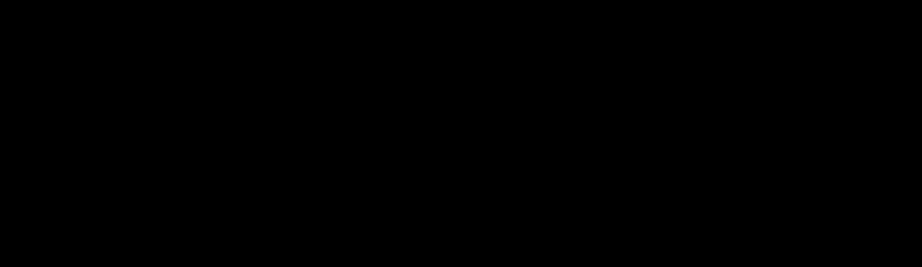
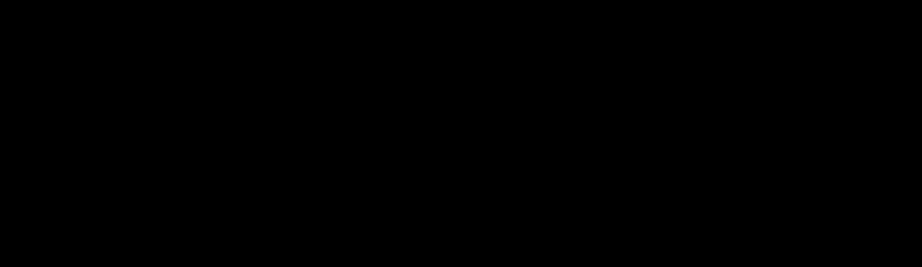